In [2]:
import numpy as np
import pandas as pd
import math
from apyori import apriori

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
df=pd.read_csv('Laundry_Data.csv')

# Data Cleaning

In [4]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             807 non-null    int64  
 1   Date           807 non-null    object 
 2   Time           807 non-null    object 
 3   Race           752 non-null    object 
 4   Gender         716 non-null    object 
 5   Body_Size      709 non-null    object 
 6   Age_Range      756 non-null    float64
 7   With_Kids      725 non-null    object 
 8   Kids_Category  777 non-null    object 
 9   Basket_Size    752 non-null    object 
 10  Basket_colour  717 non-null    object 
 11  Attire         776 non-null    object 
 12  Shirt_Colour   720 non-null    object 
 13  shirt_type     770 non-null    object 
 14  Pants_Colour   802 non-null    object 
 15  pants_type     712 non-null    object 
 16  Wash_Item      718 non-null    object 
 17  Washer_No      807 non-null    int64  
 18  Dryer_No  

,No,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,Attire,Shirt_Colour,shirt_type,Pants_Colour,pants_type,Wash_Item,Washer_No,Dryer_No,Spectacles
0,1,19/10/2015,20:17:50,malay,NaN,moderate,NaN,yes,young,big,red,casual,blue,short_sleeve,black,short,clothes,3,10,no
1,2,19/10/2015,20:28:42,indian,male,thin,32.0,no,no_kids,big,green,casual,NaN,short_sleeve,blue_jeans,long,NaN,6,9,no
2,3,19/10/2015,20:58:31,malay,female,NaN,30.0,no,no_kids,big,blue,casual,red,short_sleeve,black,long,NaN,4,10,no
3,4,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,NaN,black,casual,NaN,short_sleeve,yellow,short,clothes,5,9,no
4,5,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,casual,blue,short_sleeve,white,long,clothes,3,9,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,803,09/12/2015,20:05:46,malay,female,moderate,45.0,NaN,no_kids,small,white,casual,red,long sleeve,black,long,clothes,3,10,no
803,804,09/12/2015,20:33:01,malay,male,fat,34.0,no,no_kids,big,grey,casual,white,short_sleeve,black,long,blankets,3,7,no
804,805,09/12/2015,20:37:01,malay,female,moderate,53.0,no,no_kids,big,purple,traditional,pink,long sleeve,pink,long,clothes,3,7,yes
805,806,09/12/2015,20:42:57,indian,female,moderate,37.0,no,no_kids,big,green,traditional,brown,short_sleeve,black,long,clothes,6,10,no


In [5]:
def fill_null_val(df):
    return df.fillna('Unknown')

def change_to_date(df):
    date=pd.to_datetime(df['Date'], infer_datetime_format=True)
    return df.assign(Date=date)

def change_to_time(df):
    time=pd.to_datetime(df['Time'], infer_datetime_format=True)
    time=pd.DatetimeIndex(time).time
    return df.assign(Time=time)

def get_day_col(df):
    dayCol=pd.DatetimeIndex(df['Date']).day
    return df.assign(Day=dayCol)

def get_month_col(df):
    monthCol=pd.DatetimeIndex(df['Date']).month
    return df.assign(Month=monthCol)

def get_month_col(df):
    monthCol=pd.DatetimeIndex(df['Date']).month
    return df.assign(Month=monthCol)

def get_time_of_day(df):
    timeOfDay=pd.cut(pd.DatetimeIndex(df['Time']).hour, bins=[-1,4,11,15,19,23], labels=["Midnight","Morning", "Afternoon", "Evening","Night"]).astype(str)
    return df.assign(Time_Of_Day=timeOfDay)

def fill_age(df):
    age=df['Age_Range'].fillna(round(df['Age_Range'].mean()))
    age=age.astype('int64') 
    return df.assign(Age_Range=age)

def fill_withKids_yes(df):
    with_kids = np.where(df["Kids_Category"]=='no_kids',df['With_Kids'],'yes')
    return df.assign(With_Kids=with_kids)

def drop_no(df):
    return df.drop('No',axis=1)

def fill_withKids_no(df):
    with_kids = np.where(df["Kids_Category"]!='no_kids',df['With_Kids'],'no')
    return df.assign(With_Kids=with_kids)

def W6_big(df):
    washer = np.where(df["Washer_No"]!=6,df['Basket_Size'],'big')
    return df.assign(Basket_Size=washer)

def bin_age(df):
    age_group= pd.cut(x=df['Age_Range'], bins=[20, 30, 40, 50,60]).astype(str)
    return df.assign(Age_Group=age_group)




def mark_washer(df):
    washer = df['Washer_No'].apply(lambda x: "{}{}".format('W_', x))
    return df.assign(Washer_No=washer)

def mark_dryer(df):
    dryer = df['Dryer_No'].apply(lambda x: "{}{}".format('D_', x))
    return df.assign(Dryer_No=dryer)

def mark_shirt(df):
    shirt = df['shirt_type'].apply(lambda x: "{}{}".format('S_', x))
    return df.assign(shirt_type=shirt)

def mark_pants(df):
    pants = df['pants_type'].apply(lambda x: "{}{}".format('P_', x))
    return df.assign(pants_type=pants)

arm_drop=['Date','Time','Age_Range','Race','Gender','Body_Size','With_Kids','Kids_Category','Spectacles']

arm_select1=['Time_Of_Day','Basket_Size','Basket_colour','Washer_No','Dryer_No','Wash_Item']
arm_select2=['Time_Of_Day','Gender','Body_Size','Age_Group','Attire','Kids_Category','Spectacles']


cluster_select=['Time_Of_Day','Race','Gender','Age_Group','Age_Range','Body_Size','With_Kids','Kids_Category','Basket_Size']

classifier1_select=['Time_Of_Day','Race','Gender','Body_Size','With_Kids','Kids_Category','Basket_Size','Basket_colour','Attire','Shirt_Colour','shirt_type','Pants_Colour','pants_type','Wash_Item','Washer_No','Dryer_No']
def drop_arm(df):
    return df.drop(columns=arm_drop)

def select_arm1(df):
    return df[arm_select1]

def select_arm2(df):
    return df[arm_select2]


def select_cluster(df):
    return df[cluster_select]

def select_classifier1(df):
    return df[classifier1_select]

# Applying ARM

In [6]:
arm1=(df.pipe(mark_washer)
        .pipe(mark_dryer)
        .pipe(get_time_of_day)
        .pipe(select_arm1) 
    )

In [7]:
arm1

,Time_Of_Day,Basket_Size,Basket_colour,Washer_No,Dryer_No,Wash_Item
0,Night,big,red,W_3,D_10,clothes
1,Night,big,green,W_6,D_9,NaN
2,Night,big,blue,W_4,D_10,NaN
3,Night,NaN,black,W_5,D_9,clothes
4,Night,big,blue,W_3,D_9,clothes
...,...,...,...,...,...,...
802,Night,small,white,W_3,D_10,clothes
803,Night,big,grey,W_3,D_7,blankets
804,Night,big,purple,W_3,D_7,clothes
805,Night,big,green,W_6,D_10,clothes


In [8]:
records = []

# Iterate over each row 
for index, rows in arm1.iterrows(): 
    columns=arm1.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records.append(my_list)
    
records

[['Night', 'big', 'red', 'W_3', 'D_10', 'clothes'],
 ['Night', 'big', 'green', 'W_6', 'D_9', 'nan'],
 ['Night', 'big', 'blue', 'W_4', 'D_10', 'nan'],
 ['Night', 'nan', 'black', 'W_5', 'D_9', 'clothes'],
 ['Night', 'big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['Night', 'small', 'white', 'W_4', 'D_8', 'clothes'],
 ['Night', 'big', 'pink', 'W_5', 'D_10', 'clothes'],
 ['Midnight', 'big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['Midnight', 'small', 'purple', 'W_6', 'D_10', 'clothes'],
 ['Midnight', 'small', 'pink', 'W_5', 'D_7', 'nan'],
 ['Midnight', 'big', 'red', 'W_4', 'D_8', 'nan'],
 ['Morning', 'nan', 'blue', 'W_4', 'D_8', 'nan'],
 ['Morning', 'big', 'blue', 'W_3', 'D_7', 'clothes'],
 ['Morning', 'big', 'yellow', 'W_3', 'D_9', 'clothes'],
 ['Morning', 'big', 'red', 'W_3', 'D_8', 'clothes'],
 ['Morning', 'big', 'brown', 'W_5', 'D_9', 'clothes'],
 ['Morning', 'nan', 'nan', 'W_4', 'D_7', 'clothes'],
 ['Morning', 'big', 'blue', 'W_5', 'D_9', 'clothes'],
 ['Morning', 'nan', 'blue', 'W_6', 'D_7', 'n

In [9]:
association_rules = apriori(records, min_support=0.02, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

6

In [10]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) blankets -> Morning
Support: 0.021
Confidence: 0.6071
Lift: 2.1029
(Rule 2) blankets -> W_3
Support: 0.037
Confidence: 0.6522
Lift: 2.2588
(Rule 3) W_6 -> D_10
Support: 0.021
Confidence: 0.68
Lift: 2.8142
(Rule 4) blankets -> big
Support: 0.033
Confidence: 0.6279
Lift: 2.1748
(Rule 5) big -> W_3
Support: 0.03
Confidence: 0.6
Lift: 2.1237
(Rule 6) D_10 -> clothes
Support: 0.021
Confidence: 0.68
Lift: 3.286


In [11]:
arm2=(df.pipe(fill_age)
        .pipe(bin_age)
        .pipe(get_time_of_day)
        .pipe(select_arm2)
    )

In [12]:
arm2

,Time_Of_Day,Gender,Body_Size,Age_Group,Attire,Kids_Category,Spectacles
0,Night,NaN,moderate,"(40, 50]",casual,young,no
1,Night,male,thin,"(30, 40]",casual,no_kids,no
2,Night,female,NaN,"(20, 30]",casual,no_kids,no
3,Night,male,thin,"(50, 60]",casual,no_kids,no
4,Night,male,moderate,"(30, 40]",casual,no_kids,no
...,...,...,...,...,...,...,...
802,Night,female,moderate,"(40, 50]",casual,no_kids,no
803,Night,male,fat,"(30, 40]",casual,no_kids,no
804,Night,female,moderate,"(50, 60]",traditional,no_kids,yes
805,Night,female,moderate,"(30, 40]",traditional,no_kids,no


In [13]:
records2 = []

# Iterate over each row 
for index, rows in arm2.iterrows(): 
    columns=arm2.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records2.append(my_list)
    
records2

[['Night', 'nan', 'moderate', '(40, 50]', 'casual', 'young', 'no'],
 ['Night', 'male', 'thin', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Night', 'female', 'nan', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'thin', '(50, 60]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'fat', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['Night', 'female', 'fat', '(40, 50]', 'traditional', 'no_kids', 'no'],
 ['Midnight', 'male', 'thin', '(40, 50]', 'casual', 'nan', 'no'],
 ['Midnight', 'male', 'thin', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['Midnight', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Midnight', 'female', 'nan', '(40, 50]', 'nan', 'no_kids', 'no'],
 ['Morning', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Morning', 'female', 'moderate', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['Morning', 'male', 'moderate', '(40, 50]', 'casual', 'no_kids', 'yes'],
 ['Morning', 'female

In [14]:
association_rules = apriori(records2, min_support=0.015, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

23

In [15]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) female -> traditional
Support: 0.025
Confidence: 0.9524
Lift: 2.129
(Rule 2) female -> Midnight
Support: 0.022
Confidence: 0.9
Lift: 2.0119
(Rule 3) formal -> Midnight
Support: 0.019
Confidence: 0.75
Lift: 5.9926
(Rule 4) no -> Midnight
Support: 0.022
Confidence: 0.6
Lift: 2.5484
(Rule 5) fat -> traditional
Support: 0.035
Confidence: 0.6512
Lift: 2.1275
(Rule 6) female -> Midnight
Support: 0.019
Confidence: 0.625
Lift: 2.6546
(Rule 7) female -> traditional
Support: 0.019
Confidence: 0.9375
Lift: 2.0957
(Rule 8) female -> traditional
Support: 0.02
Confidence: 0.7619
Lift: 2.5943
(Rule 9) female -> Evening
Support: 0.017
Confidence: 0.8235
Lift: 2.8042
(Rule 10) female -> formal
Support: 0.017
Confidence: 0.7
Lift: 12.8386
(Rule 11) female -> no
Support: 0.02
Confidence: 0.8
Lift: 2.1167
(Rule 12) no -> formal
Support: 0.016
Confidence: 0.65
Lift: 6.397
(Rule 13) fat -> no_kids
Support: 0.016
Confidence: 0.619
Lift: 2.6293
(Rule 14) fat -> male
Support: 0.02
Confidence: 0.8889
L

# Clustering

In [16]:
cluster=(df.pipe(change_to_date)
        .pipe(fill_age)
        .pipe(fill_withKids_yes)
        .pipe(fill_withKids_no)
        .pipe(fill_null_val)
        .pipe(get_time_of_day)
        .pipe(bin_age)
        .pipe(select_cluster)
         
    )


In [17]:
cluster.info()
cluster

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Time_Of_Day    807 non-null    object
 1   Race           807 non-null    object
 2   Gender         807 non-null    object
 3   Age_Group      807 non-null    object
 4   Age_Range      807 non-null    int64 
 5   Body_Size      807 non-null    object
 6   With_Kids      807 non-null    object
 7   Kids_Category  807 non-null    object
 8   Basket_Size    807 non-null    object
dtypes: int64(1), object(8)
memory usage: 56.9+ KB


,Time_Of_Day,Race,Gender,Age_Group,Age_Range,Body_Size,With_Kids,Kids_Category,Basket_Size
0,Night,malay,Unknown,"(40, 50]",42,moderate,yes,young,big
1,Night,indian,male,"(30, 40]",32,thin,no,no_kids,big
2,Night,malay,female,"(20, 30]",30,Unknown,no,no_kids,big
3,Night,indian,male,"(50, 60]",51,thin,no,no_kids,Unknown
4,Night,indian,male,"(30, 40]",34,moderate,no,no_kids,big
...,...,...,...,...,...,...,...,...,...
802,Night,malay,female,"(40, 50]",45,moderate,no,no_kids,small
803,Night,malay,male,"(30, 40]",34,fat,no,no_kids,big
804,Night,malay,female,"(50, 60]",53,moderate,no,no_kids,big
805,Night,indian,female,"(30, 40]",37,moderate,no,no_kids,big


In [18]:
cluster_dum=pd.get_dummies(cluster,drop_first=True)
cluster_dum.columns

cluster_dum

,Age_Range,Time_Of_Day_Evening,Time_Of_Day_Midnight,Time_Of_Day_Morning,Time_Of_Day_Night,Race_chinese,Race_foreigner,Race_indian,Race_malay,Gender_female,...,Body_Size_moderate,Body_Size_thin,With_Kids_yes,Kids_Category_baby,Kids_Category_no_kids,Kids_Category_toddler,Kids_Category_toddler,Kids_Category_young,Basket_Size_big,Basket_Size_small
0,42,0,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,0,1,1,0
1,32,0,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,30,0,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
3,51,0,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
4,34,0,0,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,45,0,0,0,1,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,1
803,34,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
804,53,0,0,0,1,0,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
805,37,0,0,0,1,0,0,1,0,1,...,1,0,0,0,1,0,0,0,1,0


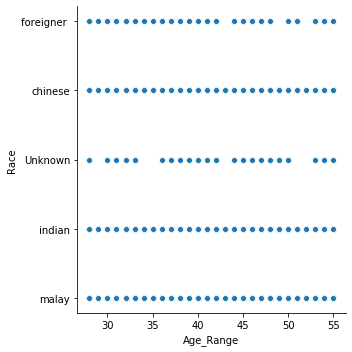

In [19]:
ax = sns.relplot(x="Age_Range", y="Race", data=cluster)

### Elbow analysis

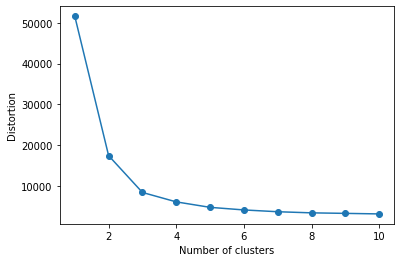

In [20]:
distortions = []

# your codes here...
for i in range(1,11):
    km=KMeans(
        n_clusters=i,
        init='random',
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=0
    )
    km.fit(cluster_dum)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

##conclusion, use k=2(elbow)

In [21]:
km=KMeans(n_clusters=3,random_state=1)
km.fit(cluster_dum)

cluster_vis=cluster.copy()
cluster_vis['label']=km.labels_



In [22]:
cluster_vis

,Time_Of_Day,Race,Gender,Age_Group,Age_Range,Body_Size,With_Kids,Kids_Category,Basket_Size,label
0,Night,malay,Unknown,"(40, 50]",42,moderate,yes,young,big,1
1,Night,indian,male,"(30, 40]",32,thin,no,no_kids,big,2
2,Night,malay,female,"(20, 30]",30,Unknown,no,no_kids,big,2
3,Night,indian,male,"(50, 60]",51,thin,no,no_kids,Unknown,0
4,Night,indian,male,"(30, 40]",34,moderate,no,no_kids,big,2
...,...,...,...,...,...,...,...,...,...,...
802,Night,malay,female,"(40, 50]",45,moderate,no,no_kids,small,1
803,Night,malay,male,"(30, 40]",34,fat,no,no_kids,big,2
804,Night,malay,female,"(50, 60]",53,moderate,no,no_kids,big,0
805,Night,indian,female,"(30, 40]",37,moderate,no,no_kids,big,2


Text(0.5, 1.0, 'Ages of Clusters')

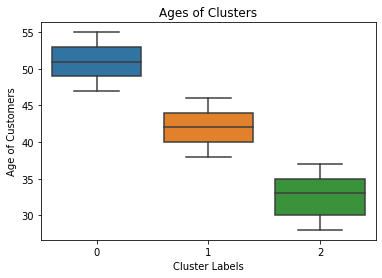

In [24]:

sns.boxplot(x="label", y="Age_Range", data=cluster_vis)
plt.xlabel('Cluster Labels')
plt.ylabel('Age of Customers')
plt.title('Ages of Clusters')

# BORUTA

In [7]:
cleaned=(df.pipe(change_to_date)
        .pipe(fill_age)
        .pipe(fill_withKids_yes)
        .pipe(fill_withKids_no)
        .pipe(fill_null_val)
        .pipe(mark_washer)
        .pipe(mark_dryer)
        .pipe(get_month_col)
        .pipe(get_time_of_day)
        .pipe(bin_age)
        #.pipe(select_classifier1)     
    )

Text(0.5, 1.0, 'Preferable Hour Of visit')

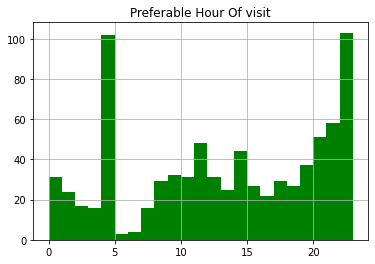

In [34]:
#hours=pd.DatetimeIndex(df['Time']).hour.astype('int64')
hours=pd.to_datetime(df['Time']).dt.hour


hours.hist(bins = 23, range=[0,23], facecolor='green')
plt.title ('Preferable Hour Of visit')

In [11]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Time_Of_Day    807 non-null    object
 1   Race           807 non-null    object
 2   Gender         807 non-null    object
 3   Body_Size      807 non-null    object
 4   With_Kids      807 non-null    object
 5   Kids_Category  807 non-null    object
 6   Basket_Size    807 non-null    object
 7   Basket_colour  807 non-null    object
 8   Attire         807 non-null    object
 9   Shirt_Colour   807 non-null    object
 10  shirt_type     807 non-null    object
 11  Pants_Colour   807 non-null    object
 12  pants_type     807 non-null    object
 13  Wash_Item      807 non-null    object
 14  Washer_No      807 non-null    object
 15  Dryer_No       807 non-null    object
dtypes: object(16)
memory usage: 101.0+ KB


In [10]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [13]:
b_cleaned=cleaned.apply(LabelEncoder().fit_transform)

y = b_cleaned.Basket_Size
X = b_cleaned.drop("Basket_Size", 1)
colnames = X.columns

In [16]:
rf = RandomForestClassifier(n_jobs=-1,class_weight="balanced",max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto",random_state =1)

feat_selector.fit(X.values,y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending=False)

In [17]:
# your codes here...
print('---------Top 10----------')
display(boruta_score.head(10))

# your codes here...
print('---------Bottom 10----------')
boruta_score.tail(10)

---------Top 10----------


,Features,Score
1,Race,1.00
6,Basket_colour,1.00
10,Pants_Colour,1.00
8,Shirt_Colour,0.92
7,Attire,0.83
13,Washer_No,0.75
0,Time_Of_Day,0.67
14,Dryer_No,0.58
3,Body_Size,0.50
12,Wash_Item,0.42


---------Bottom 10----------


,Features,Score
13,Washer_No,0.75
0,Time_Of_Day,0.67
14,Dryer_No,0.58
3,Body_Size,0.50
12,Wash_Item,0.42
5,Kids_Category,0.33
2,Gender,0.25
11,pants_type,0.17
9,shirt_type,0.08
4,With_Kids,0.00


In [14]:
X=b_cleaned[['Race','Basket_colour','Pants_Colour','Shirt_Colour','Attire','Washer_No','Time_Of_Day','Dryer_No','Body_Size','Wash_Item']]
y=cleaned['Basket_Size']

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [16]:
clf = SVC(kernel='linear',gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [20]:
confusion_majority=confusion_matrix(y_test, y_pred)
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))
mcm=multilabel_confusion_matrix(y_test, y_pred,labels=["big", "small", "Unknown"])
print(mcm)
print(classification_report(y_test,y_pred))


Accuracy on test set: 0.852
[[[  0  24]
  [  0 138]]

 [[150   0]
  [ 12   0]]

 [[150   0]
  [ 12   0]]]
              precision    recall  f1-score   support

     Unknown       0.00      0.00      0.00        12
         big       0.85      1.00      0.92       138
       small       0.00      0.00      0.00        12

    accuracy                           0.85       162
   macro avg       0.28      0.33      0.31       162
weighted avg       0.73      0.85      0.78       162



C:\Users\msi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
y_train.unique()

array(['big', 'small', 'Unknown'], dtype=object)